## Exercises

### Exercise 2.4
__Question__: If the step-size parameters, α(n) , are not constant, then the estimate Q(n) is a weighted
average of previously received rewards with a weighting different from that given by (2.6). What is
the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of
step-size parameters?

__Solution__: The essence of (2.6) is that the step parameter behaves as a discounting factor where α(n) = α. In detail, the weight given to a certain reward decays exponentially. This can be also mathematically expressed in non-constant case as:

\begin{equation*}
  Q_1\prod_{i=1}^{n} (1 - a(i)) + \sum_{i=1}^{n} a(i)R_i\prod_{j=1}^{i}(1-a(n-j)) 
\end{equation*} 

which is generalization over (2.6).

### Exercise 2.5

In [10]:
import numpy as np

%reload_ext autoreload
%autoreload 2
np.random.seed(10)

class BanditEnv(object):
    def __init__(self,num_arms = 10, mean = 0,stddev = 1):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)
        
        self.q_star = np.repeat(np.random.normal(loc=mean,scale=stddev,size=1),10) # Start out all equal
        self.optimal_action = np.argmax(self.q_star)
        self.stddev = stddev
        
    def reward(self,action):
        return np.random.normal(loc = self.q_star[action],scale = self.stddev)
    def random_walk(self):
        self.q_star += np.random.normal(loc=0,scale=0.01,size=self.q_star.shape[0])

In [11]:
class Agent(object):
    def __init__(self,env,epsilon=0.1,alpha=None):
        self.env = env
        self.q = np.repeat(0.,env.actions.shape[0])
        self.pull_count = np.repeat(0,env.actions.shape[0])
        self.epsilon = epsilon
        self.reward_history = []
        self.action_history = []
        self.alpha = alpha
        
    def inc_update_q(self,action):
        reward = self.env.reward(action)
        self.pull_count[action] += 1
        if self.alpha is None:
            self.alpha = 1.0/self.pull_count[action]
        self.q[action] +=  self.alpha * (reward - self.q[action])
        self.reward_history.append(reward)
        self.action_history.append(action)
        
    def pi(self):
        # return an action based on defined policy, when epsilon == 0, it's a greedy policy
        if np.random.random() >= self.epsilon:
            return np.argmax(self.q)
        else:
            return np.random.choice(self.env.actions)    
    def init_q(self, rounds=1):
        """Initialize q by pulling each arm a few times"""
        for _ in range(rounds):
            for action in self.env.actions:
                self.inc_update_q(action)
    def step(self, action=None):
        if action is None:
            action = self.pi()
        self.inc_update_q(action)
        self.env.random_walk()
        
    def compute_value_history(self):
        """calculate value_history based on reward_history, undiscounted"""
        return np.cumsum(self.reward_history) / (np.arange(len(self.reward_history)) + 1)
    def compute_frac_optim_action_history(self):
        optimal_action = np.argmax(self.env.q_star)
        act_hist = np.array(self.action_history)
        frac_hist = []
        for i in np.arange(act_hist.shape[0]) + 1:
            sub_hist = act_hist[:i]
            mask = sub_hist == optimal_action
            frac = sub_hist[mask].shape[0] / i
            frac_hist.append(frac)
        return frac_hist

Text(0,0.5,'% optimal actions')

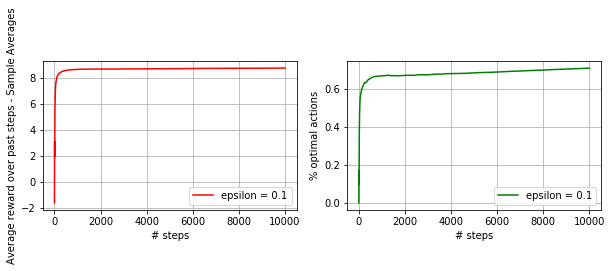

In [12]:
num_repeats = 100
num_steps = 10000
val_hist_list = []
frac_hist_list = []
bandit = BanditEnv()
for _ in range(num_repeats):
    ag = Agent(env=bandit)
    ag.init_q()
    
    for i in range(num_steps):
        ag.step()
    val_hist_list.append(ag.compute_value_history()) # append value history of each run.
    frac_hist_list.append(ag.compute_frac_optim_action_history())
val_hist_arr = np.array(val_hist_list)
frac_hist_arr = np.array(frac_hist_list)
import matplotlib.pyplot as plt

value_history_mean = val_hist_arr.mean(axis=0)
steps = np.arange(len(value_history_mean))
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.plot(steps, value_history_mean, color='red', lw=1.5, label='epsilon = 0.1')
plt.legend(loc='best')
plt.grid()
plt.xlabel('# steps')
plt.ylabel('Average reward over past steps - Sample Averages')
plt.subplot(222)
frac_history_mean = frac_hist_arr.mean(axis = 0)
steps = np.arange(len(frac_history_mean))
plt.plot(steps,frac_history_mean,color='green',lw=1.5,label='epsilon = 0.1')
plt.legend(loc='best')
plt.grid()
plt.xlabel('# steps')
plt.ylabel('% optimal actions')

As explained in textbook, sample averages method suffers from its convergent nature, thus performs suboptimally wrt constant step size below.

Text(0,0.5,'% optimal actions')

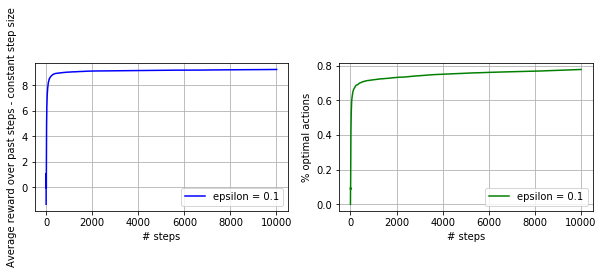

In [13]:
num_repeats = 100
num_steps = 10000
val_hist_list = []
bandit = BanditEnv()
for _ in range(num_repeats):
    ag = Agent(env=bandit,alpha=0.1)
    ag.init_q()
    
    for i in range(num_steps):
        ag.step()
    val_hist_list.append(ag.compute_value_history()) # append value history of each run.
    frac_hist_list.append(ag.compute_frac_optim_action_history())
val_hist_arr = np.array(val_hist_list)
frac_hist_arr = np.array(frac_hist_list)
import matplotlib.pyplot as plt

value_history_mean = val_hist_arr.mean(axis=0)
steps = np.arange(len(value_history_mean))
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.plot(steps, value_history_mean, color='blue', lw=1.5, label='epsilon = 0.1')
plt.legend(loc='best')
plt.grid()
plt.xlabel('# steps')
plt.ylabel('Average reward over past steps - constant step size')

frac_history_mean = frac_hist_arr.mean(axis = 0)
steps = np.arange(len(frac_history_mean))
plt.subplot(222)
plt.plot(steps,frac_history_mean,color='green',lw=1.5,label='epsilon = 0.1')
plt.legend(loc='best')
plt.grid()
plt.xlabel('# steps')
plt.ylabel('% optimal actions')

It is obvious from the resulting mean rewards that constant step size handles better the case of non-stationary data in which optimal action-values change in time.